In [16]:
# ============================================================
# 🧩 02_DATA_CLEANING – Cleaning, Scaling & Feature Filtering
# ============================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


In [17]:
# ============================================================
# 1 Load raw feature dataset
# ============================================================

df = pd.read_csv("../features_wesad_raw.csv")

print("Initial dataset shape:", df.shape)
display(df.head())
display(df.info())


Initial dataset shape: (19218, 38)


,subject,label,HR_mean,HR_std,HRV_SDNN,HRV_RMSSD,pNN50,LF_HF_ratio,RR_mean,RR_std,...,TEMP_slope,ACC_mean_magnitude,ACC_std,ACC_energy,ACC_rms_x,ACC_rms_y,ACC_rms_z,ACC_mean_x,ACC_mean_y,ACC_mean_z
0,S2,0,82.972527,32.136162,0.289972,0.472769,0.857143,NaN,0.830357,0.289972,...,0.000049,64.834768,9.564265,4295.022321,54.175887,20.424513,30.705615,53.785714,19.187500,26.433036
1,S2,0,71.267840,4.871916,0.059895,0.082186,0.428571,NaN,0.845982,0.059895,...,-0.000146,63.281737,0.794698,4005.209821,53.768477,20.136920,26.620766,53.763393,20.129464,26.611607
2,S2,0,71.769454,6.391315,0.087197,0.134563,0.428571,NaN,0.843750,0.087197,...,-0.000397,63.481564,4.885925,4053.781250,43.470433,41.739627,20.540357,38.919643,-14.383929,17.236607
3,S2,0,88.117261,34.317224,0.245690,0.264309,0.875000,NaN,0.773438,0.245690,...,-0.000640,63.397065,5.220551,4046.441964,23.278209,57.685841,13.300779,18.946429,-54.290179,10.937500
4,S2,0,100.569534,31.057347,0.193543,0.274273,0.666667,NaN,0.654514,0.193543,...,-0.000093,62.879988,2.035378,3958.035714,15.359676,59.200967,14.743188,15.125000,-59.156250,14.406250


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19218 entries, 0 to 19217
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject             19218 non-null  object 
 1   label               19218 non-null  int64  
 2   HR_mean             19215 non-null  float64
 3   HR_std              19215 non-null  float64
 4   HRV_SDNN            19215 non-null  float64
 5   HRV_RMSSD           19203 non-null  float64
 6   pNN50               19203 non-null  float64
 7   LF_HF_ratio         0 non-null      float64
 8   RR_mean             19203 non-null  float64
 9   RR_std              19203 non-null  float64
 10  IBI_median          19203 non-null  float64
 11  IBI_IQR             19203 non-null  float64
 12  TINN                19203 non-null  float64
 13  EDA_mean            19218 non-null  float64
 14  EDA_std             19218 non-null  float64
 15  EDA_median          19218 non-null  float64
 16  EDA_

None

In [18]:
# ============================================================
# 2 Drop invalid or uninformative columns
# ============================================================

# 2.1 Columns entirely NaN or constant
nan_cols = [c for c in df.columns if df[c].isna().all()]
constant_cols = [c for c in df.select_dtypes(include=[np.number]).columns if df[c].nunique() <= 1]

# 2.2 Columns with >40% missing values
na_threshold = 0.4 * len(df)
high_na_cols = [c for c in df.columns if df[c].isna().sum() > na_threshold]

drop_cols = list(set(nan_cols + constant_cols + high_na_cols))

if drop_cols:
    print(f"\nDropping {len(drop_cols)} invalid/uninformative columns:")
    print(drop_cols)
    df = df.drop(columns=drop_cols)
else:
    print("No invalid columns found.")



Dropping 6 invalid/uninformative columns:
['TEMP_slope', 'SCR_rise_time_mean', 'LF_HF_ratio', 'TEMP_std', 'Resp_band_energy', 'TEMP_mean']


In [19]:
# ============================================================
# 3 Fill missing values with column median
# ============================================================

df = df.fillna(df.median(numeric_only=True))
print("Filled missing values with column medians")


Filled missing values with column medians


In [20]:
# ============================================================
# 4 Keep only main emotional states (0=baseline, 1=amusement, 2=stress)
# ============================================================

if "label" not in df.columns:
    raise ValueError("'label' column not found in dataset!")

df = df[df["label"].isin([0, 1, 2])].reset_index(drop=True)
print("Remaining unique labels:", df["label"].unique())


Remaining unique labels: [0 1 2]


In [21]:
# ============================================================
# 5 Add binary label (1 = stress, 0 = non-stress)
# ============================================================

df["binary_label"] = df["label"].apply(lambda x: 1 if x == 2 else 0)

print("\n3-class label distribution:")
display(df["label"].value_counts().sort_index())

print("\nBinary label distribution (0=non-stress, 1=stress):")
display(df["binary_label"].value_counts().sort_index())



3-class label distribution:


label
0    11389
1     5005
2     2824
Name: count, dtype: int64


Binary label distribution (0=non-stress, 1=stress):


binary_label
0    16394
1     2824
Name: count, dtype: int64

In [22]:
# ============================================================
# 6 Feature filtering — Near-zero variance & Entropy test
# ============================================================

feature_cols = [c for c in df.columns if c not in ["subject", "label", "binary_label"]]
df_features = df[feature_cols]

# --- Variance ---
variances = df_features.var(numeric_only=True)
nzv_cols = variances[variances < 1e-5].index.tolist()

# --- Entropy ---
entropies = {}
for c in feature_cols:
    vals = df_features[c].dropna().values
    hist, _ = np.histogram(vals, bins=20, density=True)
    hist = hist[hist > 0]
    entropies[c] = entropy(hist)
entropy_series = pd.Series(entropies)
low_entropy_cols = entropy_series[entropy_series < 0.1].index.tolist()

# --- Merge low-information columns ---
low_info_cols = list(set(nzv_cols + low_entropy_cols))
if low_info_cols:
    print(f"\nDropping {len(low_info_cols)} low-information columns (NZV + low entropy):")
    print(low_info_cols)
    df = df.drop(columns=low_info_cols)
else:
    print("No low-information features detected.")


No low-information features detected.


In [23]:
# ============================================================
# 7 Scale numerical feature columns
# ============================================================

feature_cols = [c for c in df.columns if c not in ["subject", "label", "binary_label"]]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

print(f"Scaled {len(feature_cols)} feature columns")
print("Example columns:", feature_cols[:8])


Scaled 30 feature columns
Example columns: ['HR_mean', 'HR_std', 'HRV_SDNN', 'HRV_RMSSD', 'pNN50', 'RR_mean', 'RR_std', 'IBI_median']


In [24]:
# ============================================================
# 8 Sanity checks and descriptive summary
# ============================================================

missing = df.isna().sum().sum()
print(f"\nRemaining missing values: {missing}")
print("Final dataset shape:", df.shape)

desc = df.describe().T
desc["missing_%"] = (df.isna().sum() / len(df) * 100)
desc["var"] = df.var(numeric_only=True)
desc["entropy"] = entropy_series.reindex(desc.index)
desc.to_csv("wesad_feature_report.csv", index=True)

display(desc.head(10))



Remaining missing values: 0
Final dataset shape: (19218, 33)


,count,mean,std,min,25%,50%,75%,max,missing_%,var,entropy
label,19218.0,5.543241e-01,0.735505,0.000000,0.000000,0.000000,1.000000,2.000000,0.0,0.540968,NaN
HR_mean,19218.0,3.667699e-16,1.000026,-3.010765,-0.762686,-0.052731,0.692260,3.598116,0.0,1.000052,2.514123
HR_std,19218.0,2.839509e-16,1.000026,-1.812567,-0.873021,0.026760,0.822778,2.988114,0.0,1.000052,2.753432
HRV_SDNN,19218.0,2.484570e-16,1.000026,-1.802160,-0.624998,-0.068610,0.505030,20.088775,0.0,1.000052,1.241337
HRV_RMSSD,19218.0,-2.366257e-16,1.000026,-1.672709,-0.615321,-0.082758,0.483342,25.048928,0.0,1.000052,1.039571
pNN50,19218.0,4.969141e-16,1.000026,-2.912621,-0.395670,0.323459,0.711789,1.294283,0.0,1.000052,2.694375
RR_mean,19218.0,-1.893006e-16,1.000026,-2.450359,-0.707716,-0.094309,0.591916,9.098147,0.0,1.000052,1.944280
RR_std,19218.0,-1.064816e-16,1.000026,-1.823146,-0.630733,-0.068087,0.512446,17.926755,0.0,1.000052,1.347686
IBI_median,19218.0,-2.129632e-16,1.000026,-2.435502,-0.718269,-0.050456,0.617357,8.249505,0.0,1.000052,2.034997
IBI_IQR,19218.0,0.000000e+00,1.000026,-1.499636,-0.778754,-0.109364,0.585772,12.866506,0.0,1.000052,1.632720


In [25]:
# ============================================================
# 9 Save cleaned dataset
# ============================================================

output_path = "wesad_cleaned_ready.csv"
df.to_csv(output_path, index=False)
print(f"\nSaved cleaned dataset to: {output_path}")
print("Also saved feature report → wesad_feature_report.csv")


Saved cleaned dataset to: wesad_cleaned_ready.csv
Also saved feature report → wesad_feature_report.csv


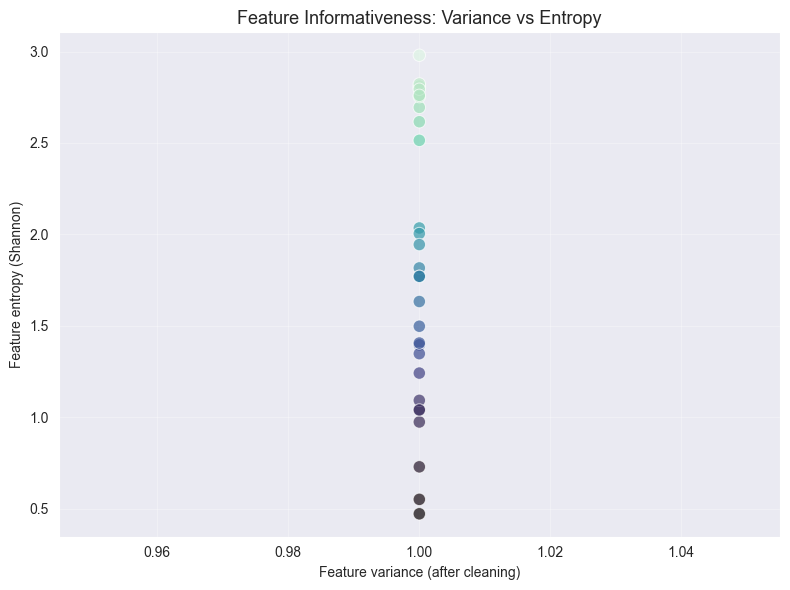

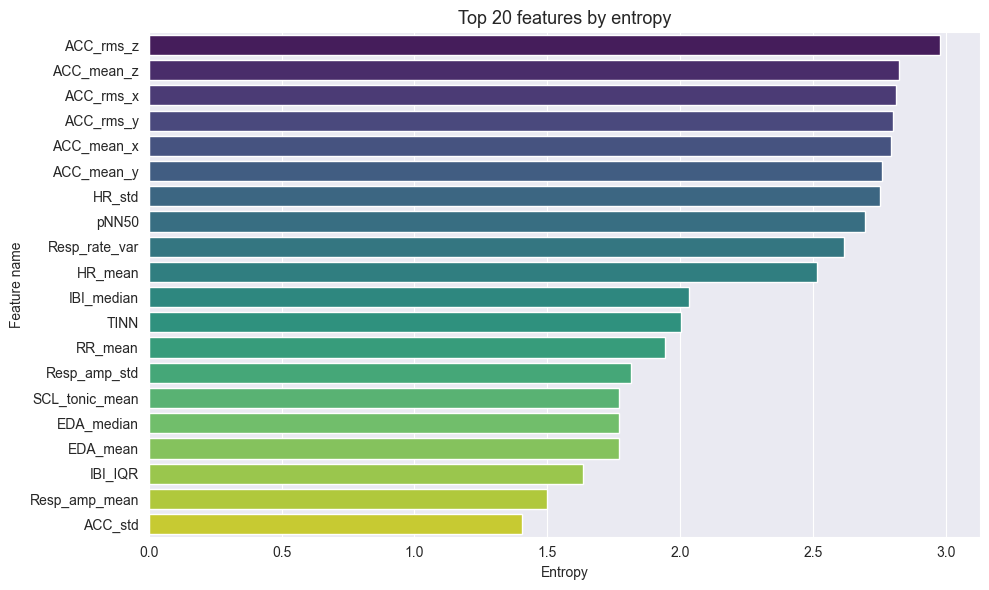

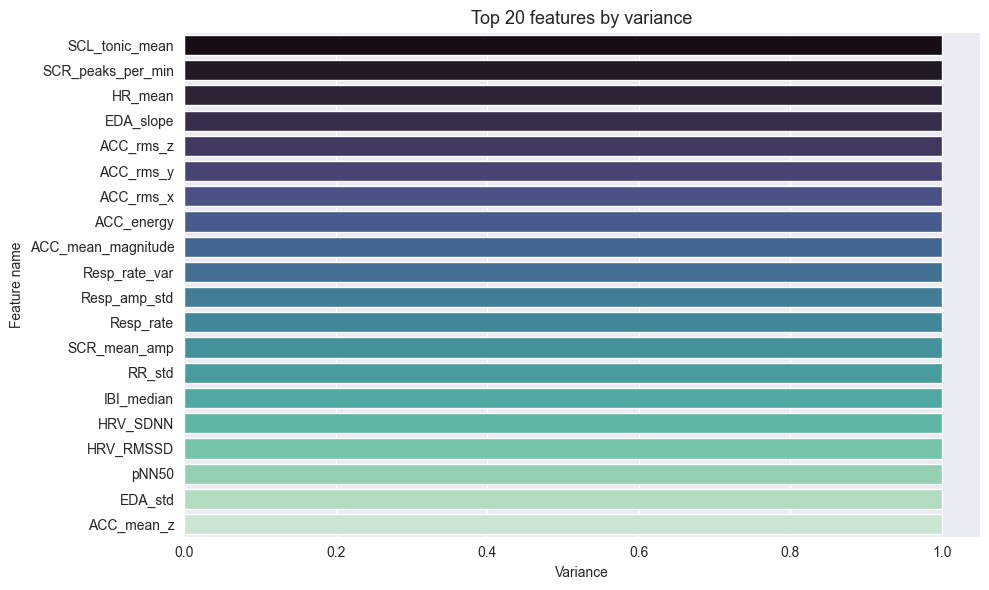

In [26]:
# ============================================================
# Visualization – Feature Variance vs Entropy (clean version)
# ============================================================

# Przygotowanie danych do wizualizacji
feature_metrics = pd.DataFrame({
    "variance": df[feature_cols].var(numeric_only=True),
    "entropy": [entropy_series.get(c, np.nan) for c in feature_cols]
}).dropna().reset_index().rename(columns={"index": "feature"})

feature_metrics = feature_metrics.sort_values("variance", ascending=False)

# --- 1 Scatter plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=feature_metrics, x="variance", y="entropy", hue="entropy",
                palette="mako", legend=False, s=80, alpha=0.7)
plt.title("Feature Informativeness: Variance vs Entropy", fontsize=13)
plt.xlabel("Feature variance (after cleaning)")
plt.ylabel("Feature entropy (Shannon)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 2 Top 20 by entropy ---
top_n = 20
top_entropy = feature_metrics.nlargest(top_n, "entropy")
plt.figure(figsize=(10, 6))
sns.barplot(data=top_entropy, x="entropy", y="feature", hue="feature",
            palette="viridis", legend=False)
plt.title(f"Top {top_n} features by entropy", fontsize=13)
plt.xlabel("Entropy")
plt.ylabel("Feature name")
plt.tight_layout()
plt.show()

# --- 3 Top 20 by variance ---
top_var = feature_metrics.nlargest(top_n, "variance")
plt.figure(figsize=(10, 6))
sns.barplot(data=top_var, x="variance", y="feature", hue="feature",
            palette="mako", legend=False)
plt.title(f"Top {top_n} features by variance", fontsize=13)
plt.xlabel("Variance")
plt.ylabel("Feature name")
plt.tight_layout()
plt.show()
